# Mario vs Wario: Image Classification

A short exercise on image classification. I download playthroughs from two of my favourite childhood games froum YouTube, scrape frames from them and train two classifiers (logistic regression and CNN) to recognize the game from which the image comes from.

I do not own any rights to the videos or game-related content.

## Libraries and UDFs ----

In [1]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

# sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# keras 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

/Users/eryklewinson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Notebook run using keras: 2.2.0


In [2]:
# UDFs ----

def scrape_frames(video_name, dest_path, n_images, skip_seconds):
    # function for scraping frames from videos
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    # function for moving random files from one directory to another (used for creating train and test set)
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    # function for previewing a random image from a given directory
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
def img_to_1d_greyscale(img_path, size):
    # function for loading, resizing and converting an image into greyscale
    # used for logistic regression
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

def show_image(image):
    # function for viewing an image
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    # function for transforming images into a format supported by CNN
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)
    

## Downloading videos ----

### mario

In [6]:
mario_video = YouTube('https://www.youtube.com/watch?v=lXMJt5PP3kM')

In [7]:
# viewing available video formats 
print('Title:', mario_video.title, '---')
stream = mario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Game Boy Longplay [005] Super Mario Land 2: 6 Golden Coins ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [8]:
# downloading the video
mario_video.streams.get_by_itag(18).download()

### wario

In [9]:
wario_video = YouTube('https://www.youtube.com/watch?v=ZJuxdR0KH-s')

In [10]:
# viewing available video formats 
print('Title:', wario_video.title, '---')
stream = wario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Game Boy Longplay [004] Super Mario Land 3: Wario Land ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [11]:
# downloading the video
wario_video.streams.get_by_itag(18).download()

## Cutting frames from the videos ----

In [14]:
# getting frames from Mario
scrape_frames('Game Boy Longplay [005] Super Mario Land 2 6 Golden Coins.mp4', 
              'training_set/mario/mario',
              every_x_frame = 30, 
              n_images = 5000,
              skip_seconds = 60)

In [3]:
# getting frames from Wario
scrape_frames('Game Boy Longplay [004] Super Mario Land 3 Wario Land.mp4', 
              'training_set/wario/wario',
              every_x_frame = 50, 
              n_images = 5000,
              skip_seconds = 60)

## Data preprocessing ----

### Splitting data into training and test sets

In [13]:
move_random_files(path_from = 'training_set/mario/', 
                  path_to = 'test_set/mario/', 
                  n = 1000)

In [14]:
move_random_files(path_from = 'training_set/wario/', 
                  path_to = 'test_set/wario/', 
                  n = 1000)

### Previewing images

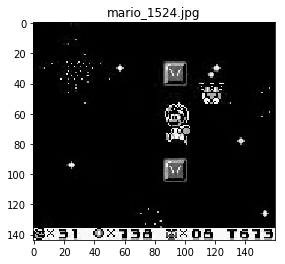

Dimensions: (160, 144) Total pixels: 23040


In [3]:
preview_random_image('training_set/mario/')

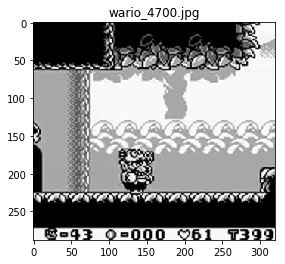

Dimensions: (320, 288) Total pixels: 92160


In [4]:
preview_random_image('training_set/wario/')

On a side note I wonder why there is a difference when I rescale the image using openCV vs Keras. The openCV one looks closer to the initial one in my opinion...

In [ ]:
im = cv2.imread('training_set/mario/mario_1.jpg')
plt.imshow(im)

In [ ]:
# using openCV
im_cv = cv2.resize(im, (64, 64)) 
plt.imshow(im_cv)

In [ ]:
# using a function from Keras
im = load_img('training_set/mario/mario_1.jpg', target_size=(64, 64))
plt.imshow(im)

### Preparing training and test sets

Used data transformations:
* rescale - value by which the data will be multiplied before any other processing. Original images consists of RGB coefficients in 0-255 range. Such values can be too high for the model to process (with a typical learning rate), so multiplying by a factor of 1/255 will rescale the variable to range 0-1
* shear_range - for randomly applying shearing transformations
* zoom_range - for randomly zooming inside pictures
* horizontal_flip - for randomly flipping half of the images horizontally (relevant when there are no assumptions of horizontal assymetry e.g. real-world pictures)

Source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html



In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
# inspecting class labels for future reference 
labels_index = { 0 : "mario", 1 : "wario" }
training_set.class_indices

{'mario': 0, 'wario': 1}

### Preview the specified transformations

In [5]:
# I transform 20 images using the aforementioned transformations and store them in preview folder

files = os.listdir('training_set/mario/')
img_name = files[randint(0, len(files) - 1)]
    
img = load_img('training_set/mario/' + img_name)  

x = img_to_array(img)          
x = x.reshape((1,) + x.shape)  

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                                save_to_dir='preview', save_prefix='mario', save_format='jpeg'):
    i += 1
    if i > 20:
        break  

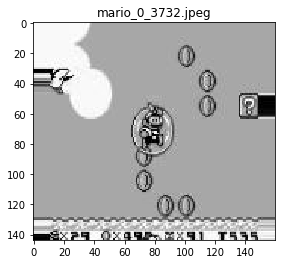

Dimensions: (160, 144) Total pixels: 23040


In [26]:
preview_random_image('preview/')

## Convolutional Neural Network approach ----

### Initialising CNN

In [5]:
# Initialising 
cnn_classifier = Sequential()

# 1st conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 3nd conv. layer
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
cnn_classifier.add(Flatten())

# Full connection
cnn_classifier.add(Dense(units = 64, activation = 'relu'))
cnn_classifier.add(Dropout(0.5)) # quite aggresive dropout, maybe reduce
cnn_classifier.add(Dense(units = 1, activation = 'sigmoid'))

cnn_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

In [6]:
# Compiling the CNN
cnn_classifier.compile(optimizer = 'adam', # 'adam'/rmsprop'
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

### Fitting the model

In [7]:
cnn_classifier.fit_generator(training_set,
                             steps_per_epoch = 2000,
                             epochs = 10,
                             validation_data = test_set,
                             validation_steps = 2000)

Epoch 1/10
2000/2000 [==============================] - 349s 175ms/step - loss: 0.2824 - acc: 0.8612 - val_loss: 0.1740 - val_acc: 0.9356
Epoch 2/10
2000/2000 [==============================] - 330s 165ms/step - loss: 0.0662 - acc: 0.9767 - val_loss: 0.2228 - val_acc: 0.9366
Epoch 3/10
2000/2000 [==============================] - 360s 180ms/step - loss: 0.0390 - acc: 0.9859 - val_loss: 0.1090 - val_acc: 0.9731
Epoch 4/10
2000/2000 [==============================] - 333s 166ms/step - loss: 0.0307 - acc: 0.9890 - val_loss: 0.1441 - val_acc: 0.9530
Epoch 5/10
2000/2000 [==============================] - 387s 194ms/step - loss: 0.0250 - acc: 0.9909 - val_loss: 0.0526 - val_acc: 0.9854
Epoch 6/10
2000/2000 [==============================] - 337s 169ms/step - loss: 0.0220 - acc: 0.9927 - val_loss: 0.1564 - val_acc: 0.9620
Epoch 7/10
2000/2000 [==============================] - 318s 159ms/step - loss: 0.0196 - acc: 0.9931 - val_loss: 0.0468 - val_acc: 0.9850
Epoch 8/10
2000/2000 [============

Tip from Keras blog:

Variance of the validation accuracy is fairly high, both because accuracy is a high-variance metric and because we only use 800 validation samples. A good validation strategy in such cases would be to do k-fold cross-validation, but this would require training k models for every evaluation round.

In [8]:
# saving model and weights 
cnn_classifier.save_weights('mario_vs_wario_weights_dropout.h5')
cnn_classifier.save('mario_vs_wario_model_dropout.h5')

In [9]:
# load the model 
cnn_classifier = keras.models.load_model('mario_vs_wario_model.h5')

### Evaluating the results

In [10]:
#preparing data for predictions

size = (64, 64)
X_eval = list()
y_eval = list()

# mario part
files = os.listdir('test_set/mario')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/mario/' + files[i + 1], size))
    y_eval.append(0)

# wario part
files = os.listdir('test_set/wario')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/wario/' + files[i + 1], size))
    y_eval.append(1)

# stacking the arrays   
X_eval = np.vstack(X_eval)
    

In [11]:
cnn_pred = cnn_classifier.predict_classes(X_eval, batch_size = 32)

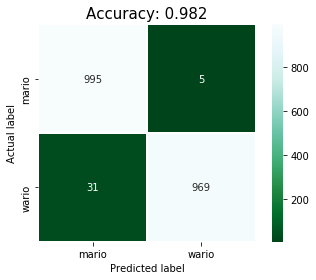

In [12]:
pretty_cm(cnn_pred, y_eval, ['mario', 'wario'])

### Explaining the results with LIME

In [13]:
correctly_classified_indices, misclassified_indices = evaluation_indices(cnn_pred, y_eval)

#### correctly classified images

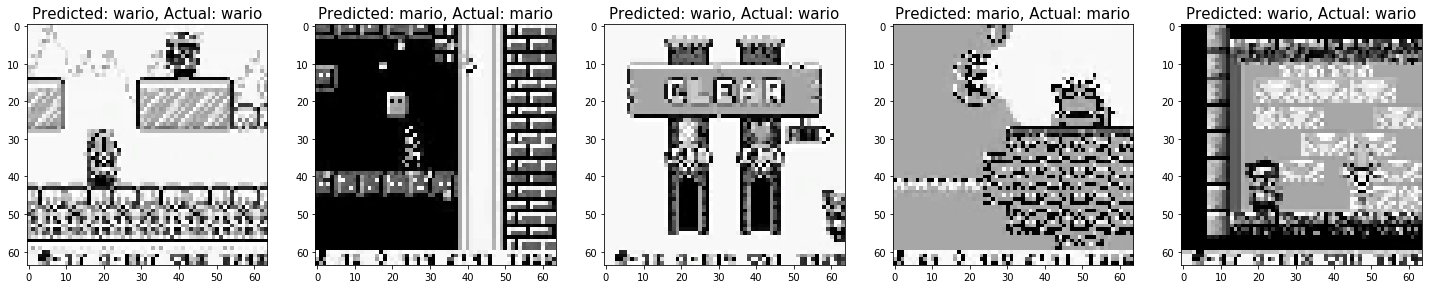

In [14]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

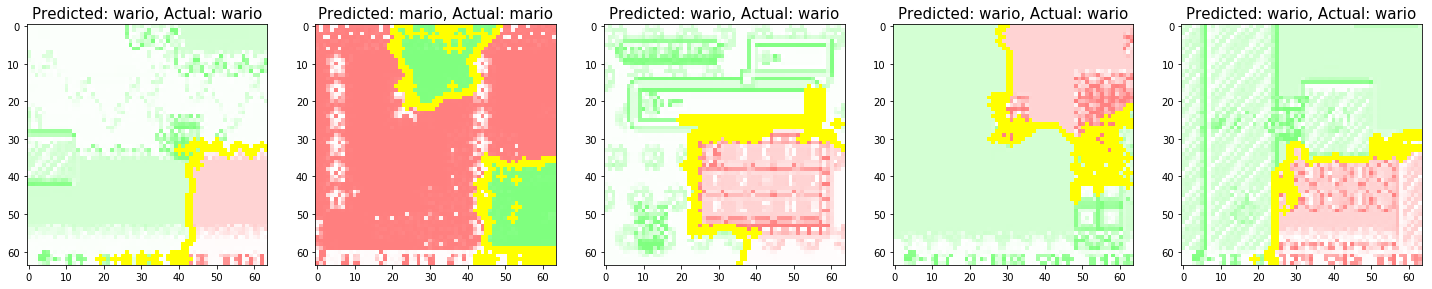

In [15]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[good_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)


#### misclassified images

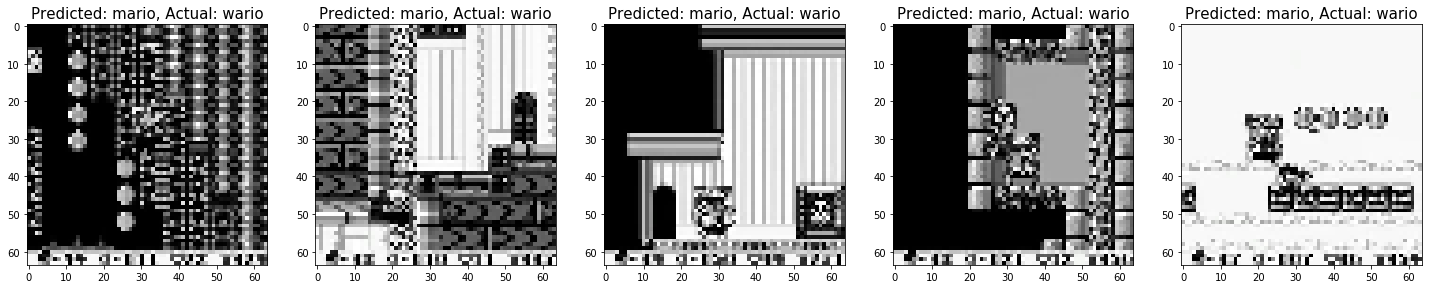

In [16]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[bad_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)

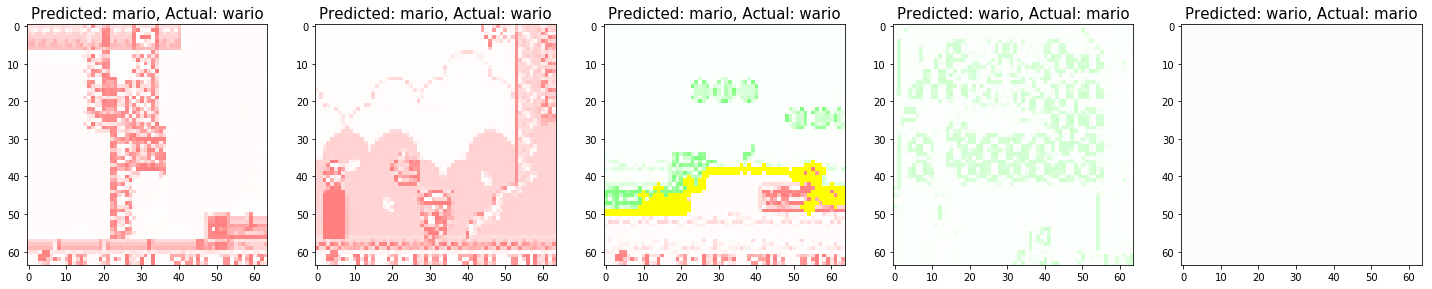

In [18]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[bad_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)


# Logistic Regression approach ----

## Preparing the data

Logistic regression requires data in a different format than the CNN from keras. I will simply prepare a large dataframe where columns correspond to pixels and observations to their values. Gor simplicity, I only consider greyscale images in this case.

In [5]:
size = (64, 64)

# defining empty containers
X_train = pd.DataFrame(np.zeros((8000, size[0] * size[1])))
X_test = pd.DataFrame(np.zeros((2000, size[0] * size[1])))
y_train = list()
y_test = list()

In [6]:
# iterating through files to create training and test set - the same split as for the CNN

counter_train = 0
counter_test = 0

# training set ----

files = os.listdir('training_set/mario')
files.sort()

for i in range(1, len(files)):
    X_train.iloc[counter_train, :] = img_to_1d_greyscale('training_set/mario/' + files[i], size) / 255
    y_train.append(0 if 'mario' in files[i] else 1)
    counter_train += 1
    
files = os.listdir('training_set/wario')
files.sort()

for i in range(1, len(files)):
    X_train.iloc[counter_train, :] = img_to_1d_greyscale('training_set/wario/' + files[i], size) / 255
    y_train.append(0 if 'mario' in files[i] else 1)
    counter_train += 1
   
# training set ----

files = os.listdir('test_set/mario')
files.sort()

for i in range(1, len(files)):
    X_test.iloc[counter_test, :] = img_to_1d_greyscale('test_set/mario/' + files[i], size) / 255
    y_test.append(0 if 'mario' in files[i] else 1)
    counter_test += 1
    
files = os.listdir('test_set/wario')
files.sort()

for i in range(1, len(files)):
    X_test.iloc[counter_test, :] = img_to_1d_greyscale('test_set/wario/' + files[i], size) / 255
    y_test.append(0 if 'mario' in files[i] else 1)  
    counter_test += 1

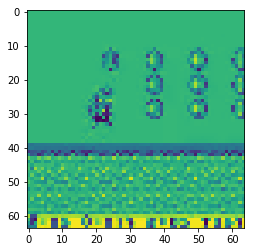

In [8]:
# example image
plt.imshow(np.reshape(X_train.iloc[0, ].values, size))

## Training the model

In [9]:
logreg_classifier = LogisticRegression(solver = 'lbfgs')

In [10]:
logreg_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

## Making predictions

In [11]:
logreg_pred = logreg_classifier.predict(X_test)

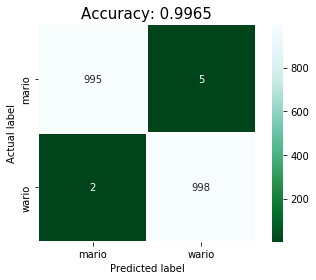

In [13]:
pretty_cm(logreg_pred, y_test, ['mario', 'wario'])

## Inspecting results

### misclassified images

In [14]:
correctly_classified_indices, misclassified_indices = evaluation_indices(logreg_pred, y_test)

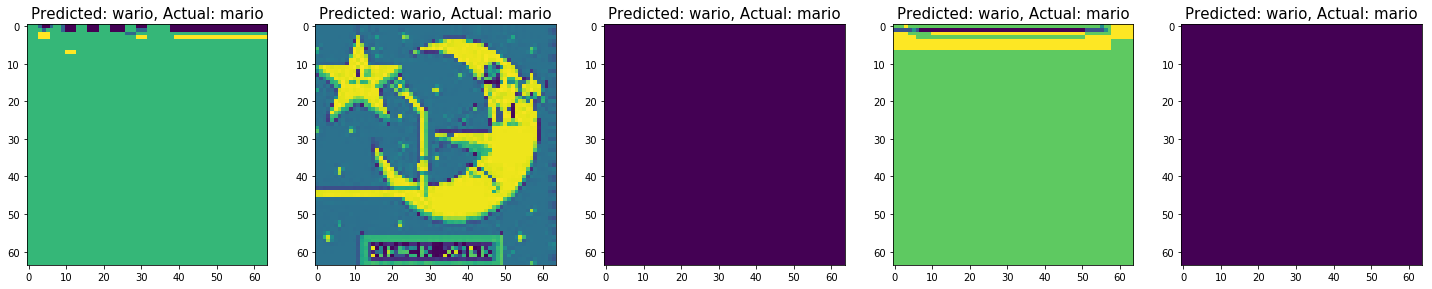

In [21]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)

for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(np.reshape(X_test.iloc[bad_index, :].values, size))
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[logreg_pred[bad_index]], 
                                                 labels_index[y_test[bad_index]]), fontsize = 15)

### correctly classified images

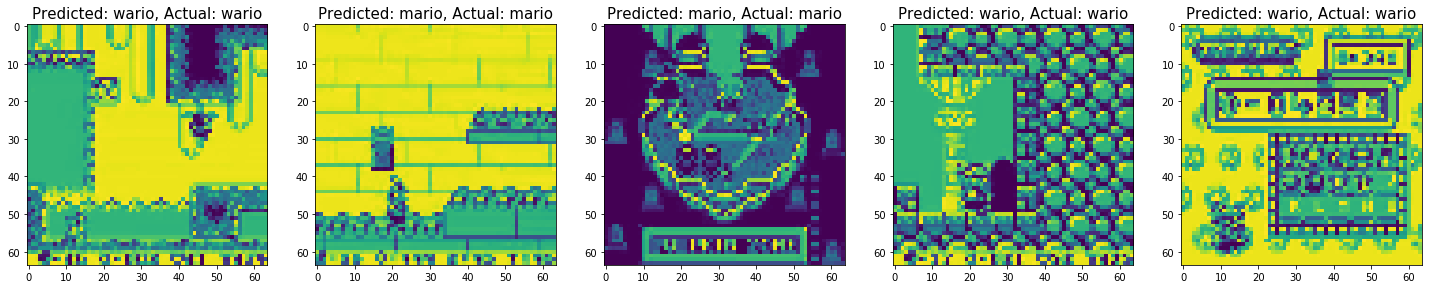

In [22]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)

for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(np.reshape(X_test.iloc[good_index, :].values, size))
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[logreg_pred[good_index]], 
                                                 labels_index[y_test[good_index]]), fontsize = 15)